In [45]:
%matplotlib widget
import cv2
import matplotlib.pyplot as plt
import numpy as np
import heapq
from pathlib import Path
from time import strftime

In [46]:
# We define this class for the graph
class Vertex:
    def __init__(self, x_coord, y_coord):
        self.x = x_coord  # x_cord of vertex
        self.y = y_coord  # y_cord of vertex
        self.d = float('inf')  # distance from source
        self.parent_x = None
        self.parent_y = None
        self.processed = False
        self.index_in_queue = None

In [47]:
# Return neighbor directly above, below, right, and left
def get_neighbors(mat, r, c):
    shape = mat.shape
    neighbors = []
    # if within the image and not processed append into neighbours array
    if r > 0 and not mat[r-1][c].processed:
        neighbors.append(mat[r-1][c])
    if r < shape[0] - 1 and not mat[r+1][c].processed:
        neighbors.append(mat[r+1][c])
    if c > 0 and not mat[r][c-1].processed:
        neighbors.append(mat[r][c-1])
    if c < shape[1] - 1 and not mat[r][c+1].processed:
        neighbors.append(mat[r][c+1])
    return neighbors

In [48]:
# We use priority queue to store the unprocessed nodes of the graph we define the reheap up and reheap down functions
def reheap_up(queue, index):
    if index <= 0:
        return queue
    p_index = (index-1)//2
    if queue[index].d < queue[p_index].d:
        queue[index], queue[p_index] = queue[p_index], queue[index]
        queue[index].index_in_queue = index
        queue[p_index].index_in_queue = p_index
        quque = reheap_up(queue, p_index)
    return queue


def reheap_down(queue, index):
    length = len(queue)
    lc_index = 2*index+1
    rc_index = lc_index+1
    if lc_index >= length:
        return queue
    if lc_index < length and rc_index >= length:  # just left child
        if queue[index].d > queue[lc_index].d:
            queue[index], queue[lc_index] = queue[lc_index], queue[index]
            queue[index].index_in_queue = index
            queue[lc_index].index_in_queue = lc_index
            queue = reheap_down(queue, lc_index)
    else:
        small = lc_index
        if queue[lc_index].d > queue[rc_index].d:
            small = rc_index
        if queue[small].d < queue[index].d:
            queue[index], queue[small] = queue[small], queue[index]
            queue[index].index_in_queue = index
            queue[small].index_in_queue = small
            queue = reheap_down(queue, small)
    return queue

# Calculating eucledian distance btw two nodes .1 is added to ensure that distance is non zero value


def get_distance(img, u, v):
    return 0.1 + (float(img[v][0])-float(img[u][0]))**2+(float(img[v][1])-float(img[u][1]))**2+(float(img[v][2])-float(img[u][2]))**2

# Function used to visualize the path


def drawPath(img, path, thickness=1):
    '''path contains all the cordinates of vertexes'''
    x0, y0 = path[0]
    for vertex in path[1:]:
        x1, y1 = vertex
        cv2.line(img, (x0, y0), (x1, y1), (255, 0, 0), thickness)
        x0, y0 = vertex

In [49]:
def find_shortest_path(img, src, dst):
    pq = []  # min-heap priority queue
    source_x = src[0]
    source_y = src[1]
    dest_x = dst[0]
    dest_y = dst[1]
    imagerows, imagecols = img.shape[0], img.shape[1]
    # Creates an empty 2d numpy array
    matrix = np.full((imagerows, imagecols), None)
    for r in range(imagerows):
        for c in range(imagecols):
            matrix[r][c] = Vertex(c, r)  # Constructor call
            matrix[r][c].index_in_queue = len(pq)
            pq.append(matrix[r][c])
    matrix[source_y][source_x].d = 0
    pq = reheap_up(pq, matrix[source_y][source_x].index_in_queue)

    while len(pq) > 0:
        u = pq[0]
        u.processed = True
        # Pop gives last element, so we exchange the first element with the last element
        pq[0] = pq[-1]
        pq[0].index_in_queue = 0
        pq.pop()
        pq = reheap_down(pq, 0)
        # Dijkistra algorithm
        neighbors = get_neighbors(matrix, u.y, u.x)
        for v in neighbors:
            dist = get_distance(img, (u.y, u.x), (v.y, v.x))
            if u.d + dist < v.d:
                v.d = u.d+dist
                v.parent_x = u.x
                v.parent_y = u.y
                idx = v.index_in_queue
                pq = reheap_down(pq, idx)
                pq = reheap_up(pq, idx)

    path = []
    d1 = matrix[dest_y][dest_x]
    path.append((dest_x, dest_y))
    while (d1.y != source_y or d1.x != source_x):
        path.append((d1.x, d1.y))
        d1 = matrix[d1.parent_y][d1.parent_x]

    path.append((source_x, source_y))
    return path

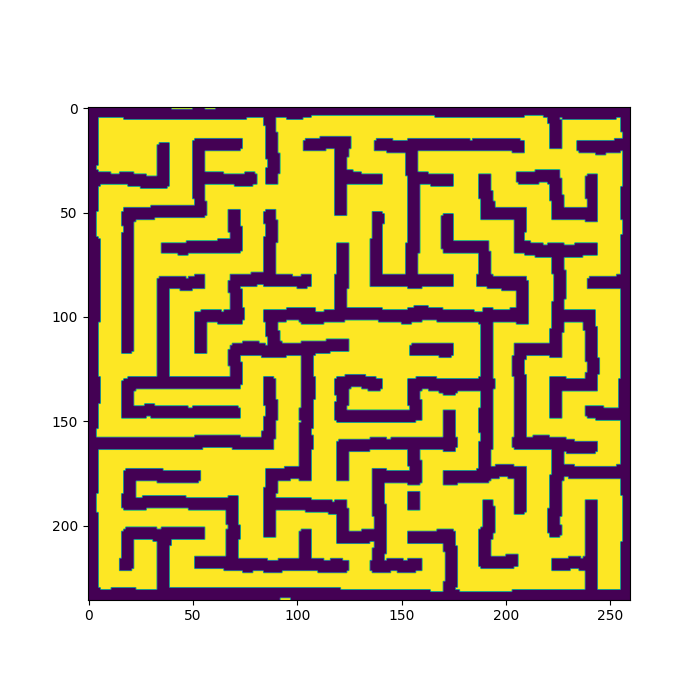

In [50]:
# Load and convert the image to grayscale
image_path = Path('img/maze_1.jpeg').absolute().__str__()
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Step 1: Thresholding to get a binary image
# Invert colors for skeletonization
_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

# plt.imshow(binary_image)
# plt.show()

dilatation_size = 2
element = cv2.getStructuringElement(cv2.MORPH_RECT, (2 * dilatation_size + 1, 2 * dilatation_size + 1),
                                    (dilatation_size, dilatation_size))
dilated_edges = cv2.dilate(binary_image, element)

# plt.imshow(dilated_edges)
# plt.show()

# Find contours and get bounding box of the largest contour (the maze boundary)
contours, _ = cv2.findContours(
    dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)
diff = 2
# Crop the image to the bounding box of the mazezx
cropped_image = dilated_edges[y+diff:y+h-diff, x+diff:x+w-diff]
# cropped_image = dilated_edges[y:y+h, x:x+w]
# plt.imshow(cropped_image)
# plt.show()

inv_cropped_img = cv2.bitwise_not(cropped_image)
plt.imshow(inv_cropped_img)
plt.show()
plt.imsave(f'img/maze_proc_{strftime("%Y%m%d_%H%M%S")}.png', inv_cropped_img)

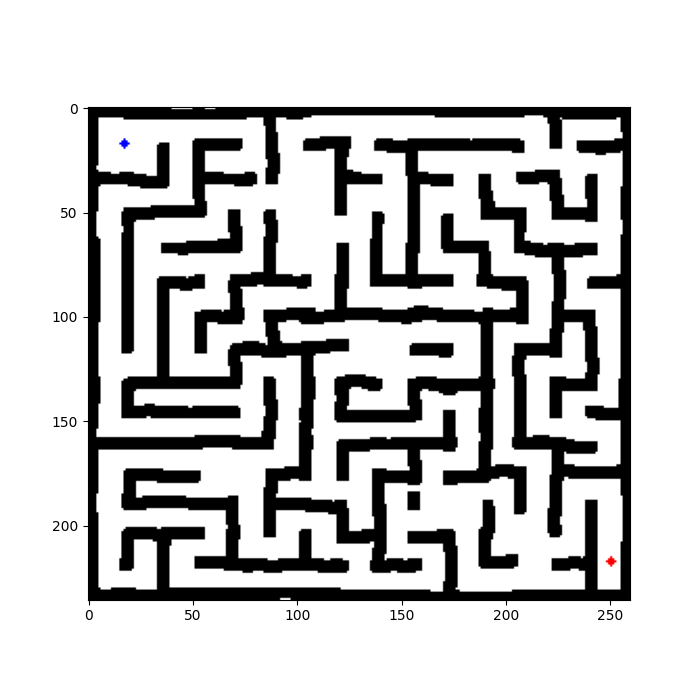

In [51]:

# img = cv2.imread('img/maze_proc_20241029_075525.png')
img = cv2.cvtColor(inv_cropped_img, cv2.COLOR_GRAY2BGR)
# Let's visualize the image by drawing circles at entry and exit point
cv2.circle(img, (250, 217), 2, (255, 0, 0), -1)
cv2.circle(img, (17, 17), 2, (0, 0, 255), -1)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()

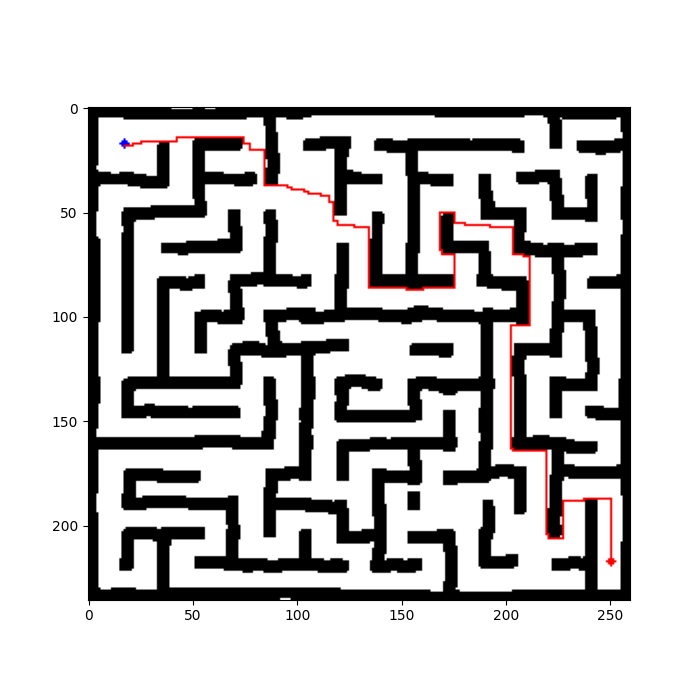

In [52]:
# img = cv2.imread('maze.png')
# cv2.circle(img, (516, 377), 2, (255, 0, 0), -1)
# cv2.circle(img, (145, 83), 2, (0, 0, 255), -1)
p = find_shortest_path(img, (250, 216), (17, 18))
drawPath(img, p)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()